In [2]:
from settings import *
from utils import SpatialTransform, load_data, CoordsImageTest
from inrmorph import InrMorph
import pandas as pd
from matplotlib.animation import FuncAnimation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [3]:
def set_wandb_logger():
    try:
        with open('logger_name.txt', 'r') as f:
            lines = f.readlines()
            if lines:
                logger_name = lines[-1].strip()
            else:
                logger_name = None
    except FileNotFoundError:
        print("The file 'logger_name.txt' does not exist.")
        logger_name = None
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        logger_name = None
        
    run = wandb.init(
        project="INRMorph",
        name="visualizations_"+logger_name
        )
    return run, logger_name


def jacobian_determinant(coords, deformation_field):
    jac = compute_jacobian_matrix(coords, deformation_field)
    return torch.det(jac)


def compute_jacobian_matrix(coords, deformation_field):

    dim = coords.shape[1]
    # print("in jac", coords.shape, deformation_field.shape, dim)
    jacobian_matrix = torch.zeros(coords.shape[0], dim, dim)

    for i in range(dim):

        jacobian_matrix[:, i, :] = gradient(coords, deformation_field[:, i])
        # print("jacobian matrix", jacobian_matrix.shape)
    return jacobian_matrix   
    
         

    
def gradient(coords, output, grad_outputs=None):
    # print("in grad", coords.shape, output.shape)

    grad_outputs = torch.ones_like(output)
 
    grad = torch.autograd.grad(output, [coords], grad_outputs=grad_outputs, create_graph=True)[0]

    return grad  


def jacobain_determinant_numerical_approx(deformation_field):
    dx, dy, dz = torch.gradient(deformation_field, dim=(0, 1, 2))  # Gradients w.r.t x, y, z

    #each dx, dy, dz is of shape (260, 260, 250, 3), where the last dimension gives (∂x/∂x, ∂x/∂y, ∂x/∂z) and so on
    #we form the Jacobian matrix for each voxel
    jacobian_matrix = torch.stack([dx, dy, dz], dim=-1)  #shape: (260, 260, 250, 3, 3)

    #compute the determinant of the Jacobian matrix at each voxel
    jacobian_determinant = torch.det(jacobian_matrix) 

    return jacobian_determinant

In [4]:
transform = SpatialTransform()
validation_batch_size = 1
spatial_reg = 0
temporal_reg = 0
time = [0, 13, 14, 24]
# time = [0, 1, 2, 5, 7, 10, 12, 13, 14, 16, 18, 20, 22, 24, 27] #0, 13, 14, 24
time = torch.tensor(time, device=device, dtype=torch.float32)
normalized_time_points = time/12
patch_size = [32, 32, 32]
batch_size = 13520
project_name = "inrmorph"
# batch_size = 13520000

datapath = "data/AD/005_S_0814/resampled/"

os.environ["WANDB_NOTEBOOK_NAME"] = "inrmorph"
I0 = load_data(datapath + "/I0.nii", True)

I0_mask = load_data(datapath + "/masks/I0.nii.gz", False)

image_vector = CoordsImageTest(I0.shape, scale_factor = 1)
test_generator = DataLoader(dataset = image_vector, batch_size=batch_size, shuffle = False)


#load model and artifact
run, logger_name = set_wandb_logger()
print("Testing for run with model name: ", logger_name)
model = InrMorph(I0, I0, patch_size, spatial_reg, temporal_reg, 4, "siren", "NCC", "finite_difference", "L2", normalized_time_points).to(device)
artifact = run.use_artifact(f'aishalawal/inrmorph/{logger_name}:best', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir + "/model.ckpt")["state_dict"])
model.eval()
print(model)

print("Number of parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Model successfully loaded")

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
wandb: Currently logged in as: aishalawal. Use `wandb login --relogin` to force relogin


Testing for run with model name:  default_multipletimepoints


wandb:   1 of 1 files downloaded.  


InrMorph(
  (t_mapping): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=10, out_features=64, bias=True)
  )
  (mapping): Siren(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=256, bias=True)
      (1): Linear(in_features=320, out_features=320, bias=True)
      (2): Linear(in_features=384, out_features=384, bias=True)
      (3): Linear(in_features=448, out_features=448, bias=True)
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): Linear(in_features=576, out_features=3, bias=True)
    )
  )
)
Number of parameters 717847
Model successfully loaded


/tmp/ipykernel_673548/2990344568.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(artifact_dir + "/model.ckpt")["state_dict"])


In [5]:
stack_total_deformation_field = []
stack_total_jac_det = []
stack_tdf = []
stack_moved_images = []
for t in normalized_time_points:
    for k, coords in enumerate(test_generator):
        coords = coords.squeeze().to(device, dtype=torch.float32).requires_grad_(True)
        displacement_vector = model.test_step(coords, t).squeeze().to(device)
        deformation_field = torch.add(displacement_vector, coords)

        jac_det = jacobian_determinant(coords, deformation_field) #shape is batch_size

        coords = coords.cpu().detach()
        deformation_field = deformation_field.cpu().detach()
        jac_det = jac_det.cpu().detach()
        
        if k==0:

            total_jac_det = jac_det
            total_deformation_field = deformation_field
        else:
            total_jac_det = torch.cat((total_jac_det, jac_det))
            total_deformation_field = torch.cat((total_deformation_field, deformation_field), 0)

    total_deformation_field = total_deformation_field.view(-1, 3).unsqueeze(0)
    stack_total_deformation_field.append(total_deformation_field)
    moved = transform.trilinear_interpolation(total_deformation_field.to(device), I0).view(I0.shape)  
    stack_moved_images.append(moved.cpu().numpy().squeeze())

    stack_total_jac_det.append(total_jac_det.view(I0.shape))
    stack_tdf.append(total_deformation_field.view(*I0.shape,3))
    print(f"Time step {t} done")
I0 = I0.cpu().numpy()
I0_mask = I0_mask.cpu().numpy()
    

Time step 0.0 done
Time step 1.0833333730697632 done
Time step 1.1666667461395264 done
Time step 2.0 done


In [6]:
#copies
stack_total_jac_det_copy = stack_total_jac_det.copy()
stack_tdf_copy = stack_tdf.copy()
stack_moved_images_copy = stack_moved_images.copy()
stack_total_deformation_field_copy = stack_total_deformation_field.copy()

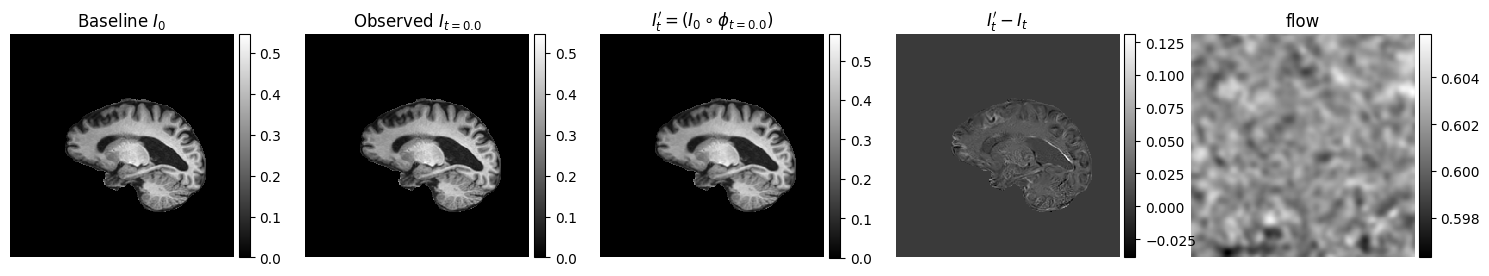

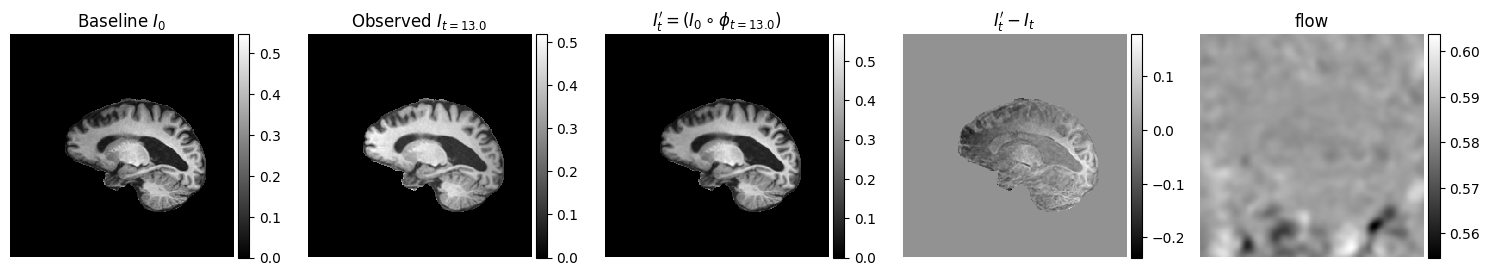

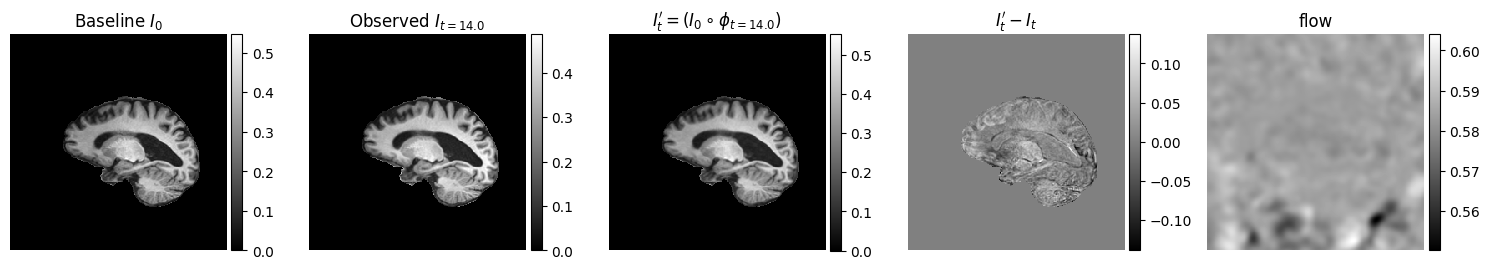

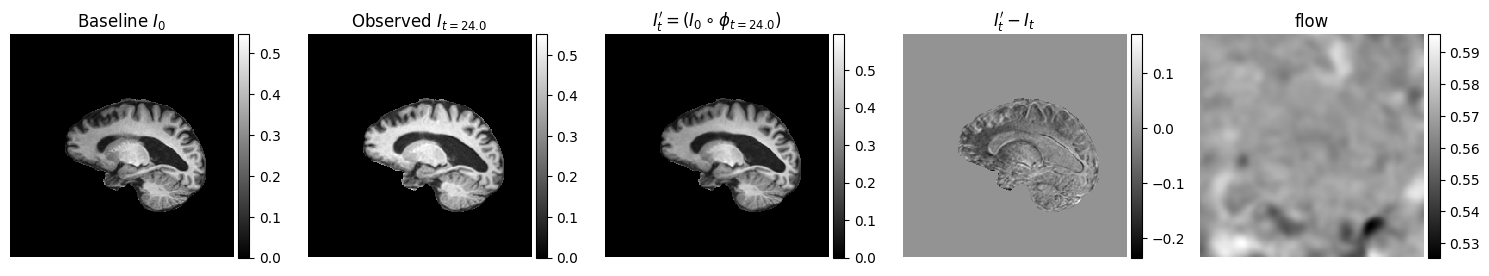

In [7]:
#visualising residuals
def image_masking(img, mask, tdf = False):

    img = (img - np.min(img))/(np.max(img) - np.min(img))
    if tdf == True:
        # mask = np.expand_dims(mask, axis=-1)
        # rows, cols = np.where(mask > 0)
        # x1, y1 = np.min(rows), np.min(cols)
        # x2, y2 = np.max(rows), np.max(cols)
        # img = img[x1-50:x2+50, y1:y2+50, :]
        
        # img = img * (mask) 
        return img 
    return img * mask

num_slice = 120
image_mask_2d = I0_mask[:, :, num_slice]
I0_2d = I0[:, :, num_slice]
masked_I0 = image_masking(I0_2d, image_mask_2d, False)
video_images = []
video_titles = []
for idx, t in enumerate(time):
    It = load_data(datapath + f"I{idx}.nii", True)
    # I0_mask = load_data(maskpath + f"I{idx}_fsl_mask.nii.gz")


    It = It.cpu().numpy()
    # I0_mask = I0_mask.cpu().numpy()

    It_2d = It[:, :, num_slice]
    moved_2d = stack_moved_images[idx][:, :, num_slice]
    tdf_2d = stack_tdf[idx][:, :, num_slice].cpu().numpy()
    plot_jac_det_2d = stack_total_jac_det[idx][:, :, num_slice].cpu().numpy()
    masked_It = image_masking(It_2d, image_mask_2d, False)

    masked_moved = image_masking(moved_2d, image_mask_2d, False)
    masked_tdf = image_masking(tdf_2d, image_mask_2d, True)
    masked_jac_det = image_masking(plot_jac_det_2d, image_mask_2d, False)

    residual = masked_moved - masked_It
    
    
    images = [masked_I0, masked_It, masked_moved,  residual , masked_tdf[..., 2]] 
    # titles = [r'Baseline $I_0$', r'Observed $I_t={}$'.format(t), r'$I_t\' (I_0 \circ \phi_t={})$'.format(t), 'It\'-It', 'flow']
    titles = [
    r'Baseline $I_0$', 
    r'Observed $I_{t=' + str(t.item()) + '}$', 
    r"$I_{t}' = (I_0 \circ \phi_{t=" + str(t.item()) + "})$", 
    r"$I_{t}' - I_t$", 
    'flow'
    ]
    video_images.append(images)
    video_titles.append(titles)
    ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

    wandb.log({"Transformed images": [wandb.Image(image, caption=title) for image, title in zip(images, titles)]})



## EVALUATING |J| maps

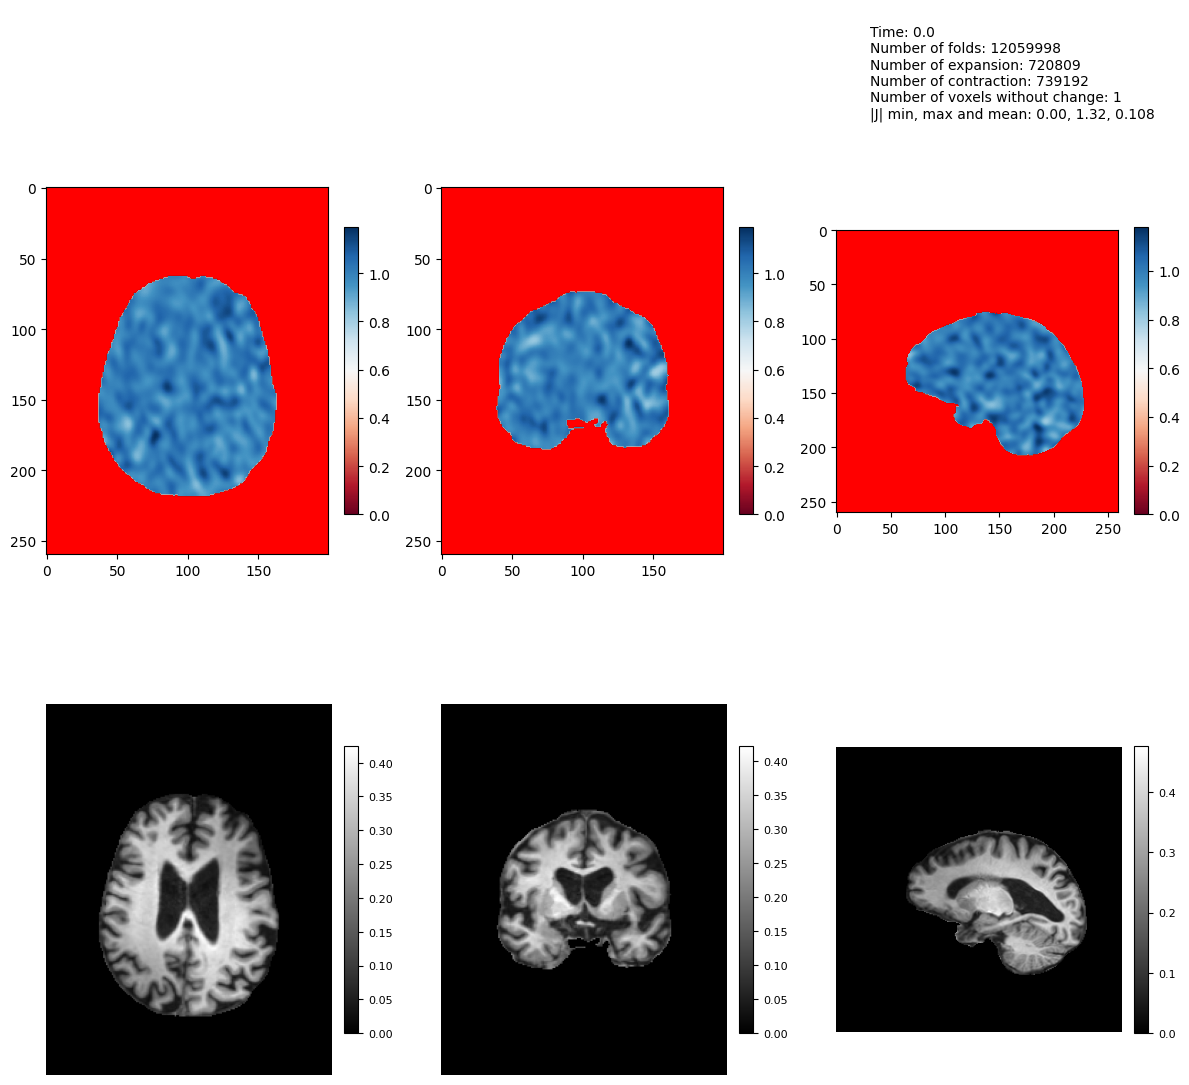

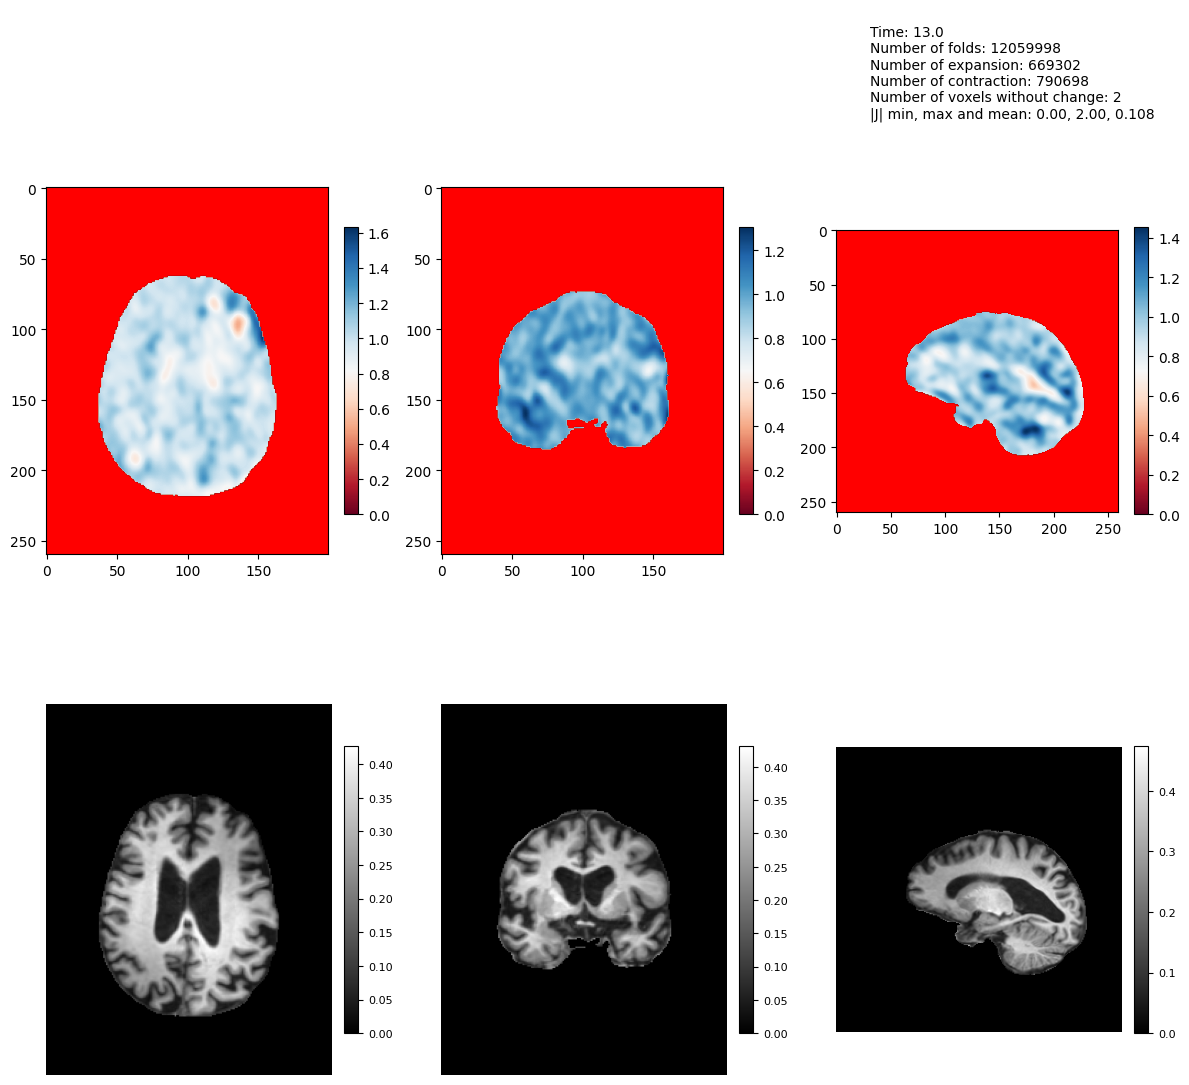

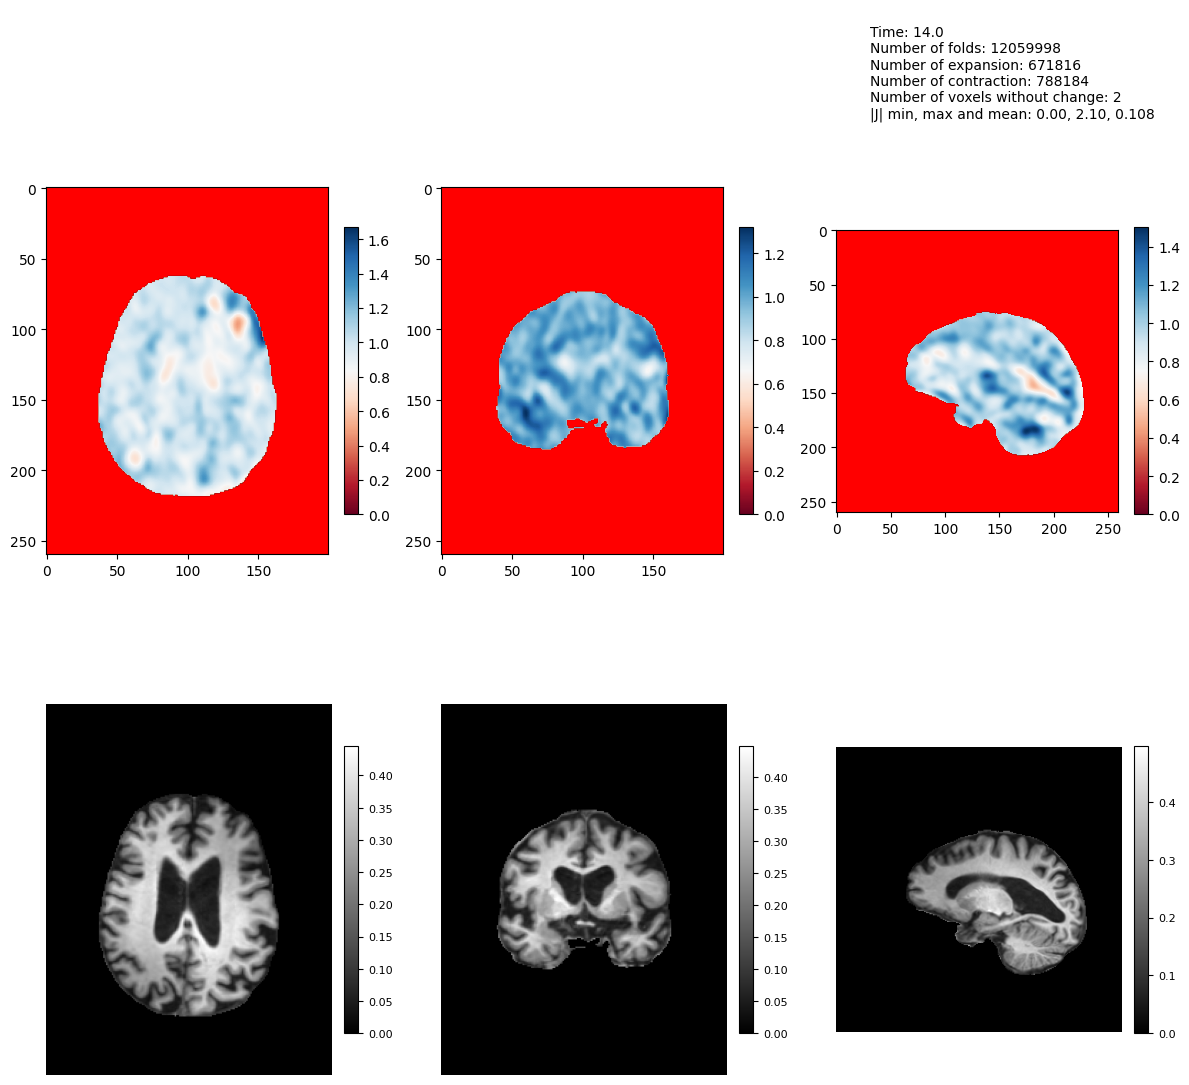

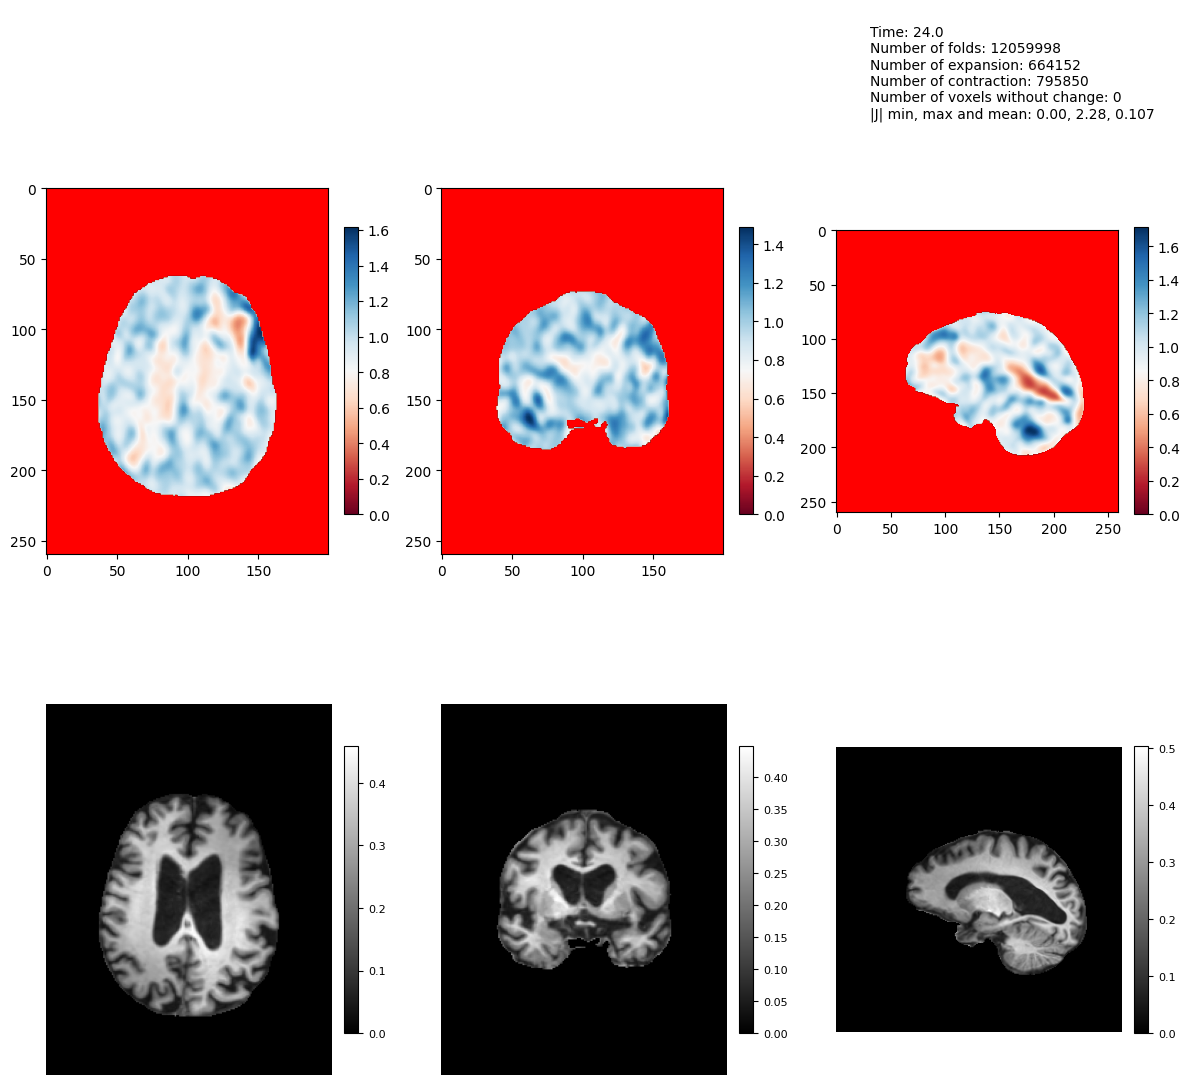

In [67]:
def preview_image(jacobian_det, mask, I0, time, normalize_by="volume", cmap=None, figsize=(12, 12), threshold=None):
    """
    Display three orthogonal slices of the given 3D image and the corresponding I0 slices.

    jacobian_det is assumed to be of shape (H,W,D)

    If a number is provided for threshold, then pixels for which the value
    is below the threshold will be shown in red
    """
    if normalize_by == "slice":
        vmin = None
        vmax = None
        
    elif normalize_by == "volume":
        vmin = jacobian_det.min().item()
        # vmax = jacobian_det.max().item()
        vmax = jacobian_det.max().item()

    else:
        raise (ValueError(f"Invalid value '{normalize_by}' given for normalize_by"))

    # half-way slices
    rows, cols, dep = np.where(mask > 0)
    x1, x2, = min(rows), max(rows)
    y1, y2 = min(cols), max(cols)
    z1, z2 = min(dep), max(dep)

    # x, y, z = np.array(jacobian_det.shape) // 2
    x = 120
    y = 125
    z = 120
    jac_det_slices = (jacobian_det[x, :, :], jacobian_det[:, y, :], jacobian_det[:, :, z])

    I0_slices = (I0[x, :, :], I0[:, y, :], I0[:, :, z])

    # jac_det_slices = (jacobian_det[x, y1:y2, z1:z2], jacobian_det[x1:x2, y, z1:z2], jacobian_det[x1:x2, y1:y2, z])

    # I0_slices = (I0[x, y1:y2, z1:z2], I0[x1:x2, y, z1:z2], I0[x1:x2, y1:y2, z])
    fig, axs = plt.subplots(2, 3, figsize=figsize)

    for i, (img, I0_slice) in enumerate(zip(jac_det_slices, I0_slices)):
        ax = axs[0, i]
        # ax.axis("off")
        #clip image, we dont really expect changes above 2.5 increase or decrease
        # img = np.clip(img, a_min = -2.5, a_max=2.5)
        # gg = ax.imshow(img, origin="upper", vmin=-2.5, vmax=2.5, cmap="coolwarm") #cmap coolwarm, RdBu, jet
        gg = ax.imshow(img, origin="upper", cmap="RdBu") #cmap coolwarm, RdBu, jet

        # gg = ax.imshow(img, origin="lower", vmin=img.min(), vmax=img.max(), cmap="RdBu")

        if threshold is not None:
            red = np.zeros(img.shape + (4,))  # RGBA array
            red[img <= threshold] = [1, 0, 0, 1]
            ax.imshow(red, origin="upper")

        # Add colorbar for the image slice
        cbar = fig.colorbar(gg, ax=ax, fraction=0.046, pad=0.05)
        # cbar.ax.tick_params(labelsize=8)

        ax = axs[1, i]
        ax.axis("off")
        hh = ax.imshow(I0_slice, origin="upper", cmap="gray")


        # Add colorbar for the I0 slice
        cbar = fig.colorbar(hh, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        fig.tight_layout()
        
        text = f"""
        Time: {time}
        Number of folds: {(det<=0).sum()}
        Number of expansion: {(det>1).sum()}
        Number of contraction: {((det > 0) & (det < 1)).sum()}
        Number of voxels without change: {(det==1).sum()}
        |J| min, max and mean: {float(det.min().item()):.2f}, {float(det.max().item()):.2f}, {float(det.mean().item()):.3f}
        
        """
    ax.set_facecolor("yellow")
    plt.figtext(0.7, 0.90, text, ha="left", fontsize=10, bbox={"facecolor": "white", "edgecolor": "white", "alpha": 0, "pad": 5, "linewidth": 3})
    wandb.log({"Jacobian Maps": wandb.Image(fig)})
    plt.show()
    return fig


video_jacobian_maps = []
for idx, selected_time in enumerate(time):
    det = stack_total_jac_det[idx] * I0_mask
    mvd = stack_moved_images[idx]
    mvd = (mvd - np.min(mvd))/(np.max(mvd) - np.min(mvd))
    mvd = mvd * I0_mask
    fig =preview_image(det, I0_mask, mvd, selected_time, normalize_by="slice", threshold=0)
    video_jacobian_maps.append(fig)
plt.close(fig)

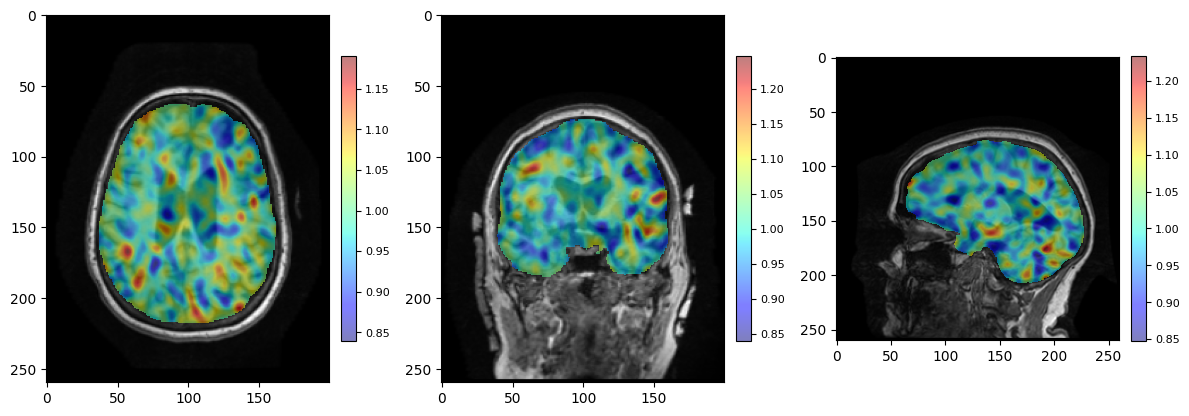

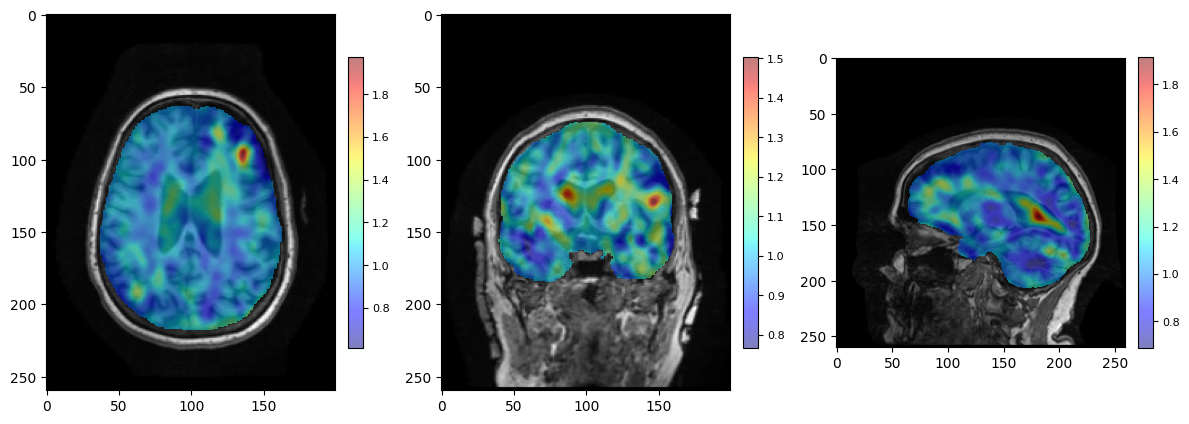

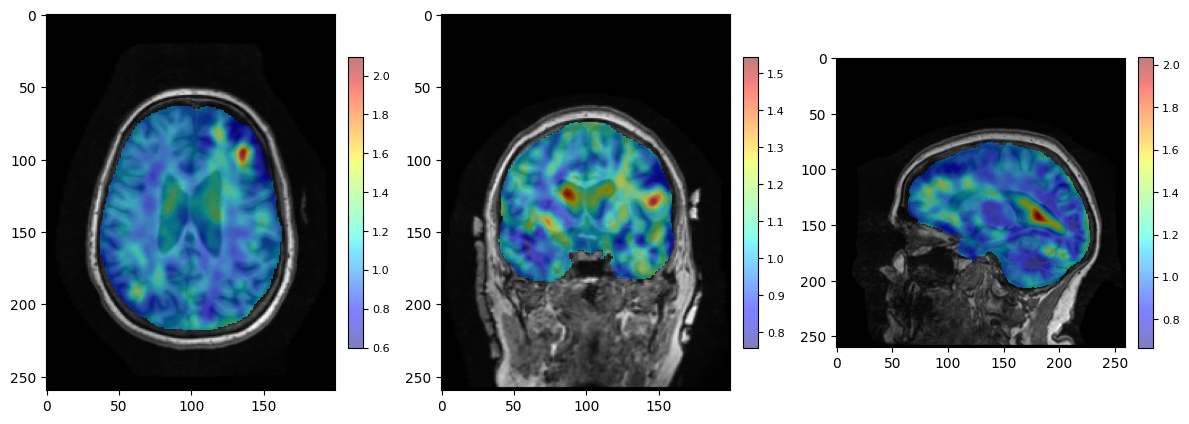

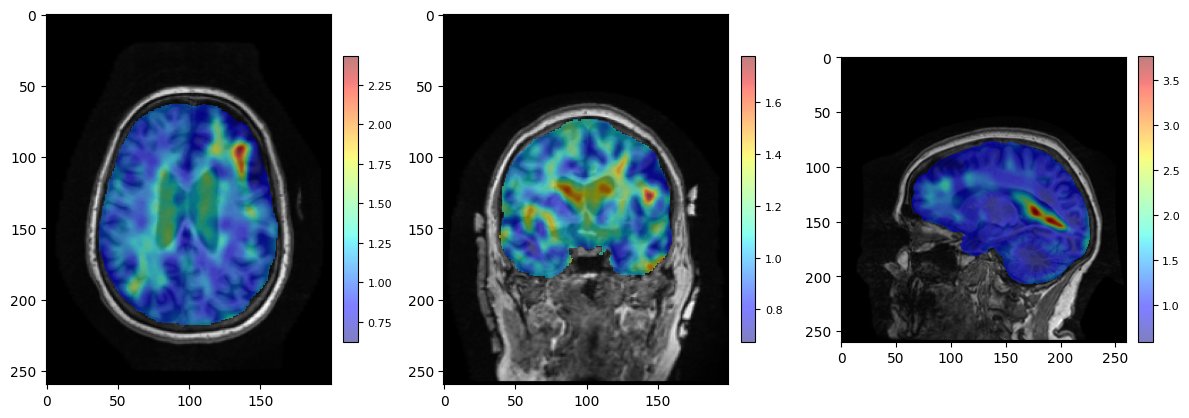

In [8]:
def preview_image(jacobian_det, mask, I0, time, normalize_by="slice", cmap="jet", alpha=0.5, figsize=(12, 12), threshold=None):
    """
    Display three orthogonal slices of the given 3D image with an overlay of the masked Jacobian determinant map.

    jacobian_det is assumed to be of shape (H, W, D)

    If a number is provided for threshold, then pixels for which the value
    is below the threshold will be shown in red
    """
    if normalize_by == "slice":
        vmin, vmax = None, None
    elif normalize_by == "volume":
        vmin = jacobian_det.min().item()
        vmax = jacobian_det.max().item()
    else:
        raise ValueError(f"Invalid value '{normalize_by}' given for normalize_by")

    #half-way slices
    x, y, z = 120, 125, 120
    jac_det_slices = (jacobian_det[x, :, :], jacobian_det[:, y, :], jacobian_det[:, :, z])
    I0_slices = (I0[x, :, :], I0[:, y, :], I0[:, :, z])
    mask_slices = (mask[x, :, :], mask[:, y, :], mask[:, :, z])

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    for i, (jac_slice, I0_slice, mask_slice) in enumerate(zip(jac_det_slices, I0_slices, mask_slices)):
        #plot the base grayscale image (unmasked)
        ax = axs[i]
        jac_slice = 1/jac_slice #invert the Jacobian determinant for correct visualization
        ax.imshow(I0_slice, origin="upper", cmap="gray")

        #mask the Jacobian map
        jac_slice_masked = np.ma.masked_where(mask_slice == 0, jac_slice)
        #make min and max values per slice
        vmin = jac_slice_masked.min()
        vmax = jac_slice_masked.max()
        #overlay the masked Jacobian map
        overlay = ax.imshow(jac_slice_masked, origin="upper", cmap=cmap,alpha=alpha, vmin=vmin, vmax=vmax)
        #add colorbar for the overlay
        cbar = fig.colorbar(overlay, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)

        # # Optional: apply threshold for highlighting areas in red
        # if threshold is not None:
        #     red = np.zeros(jac_slice.shape + (4,))  # RGBA array
        #     red[jac_slice <= threshold] = [1, 0, 0, 1]
        #     ax.imshow(red, origin="upper")

    fig.tight_layout()
    plt.show()
    return fig

video_jacobian_determinant_maps = []
for idx, selected_time in enumerate(time):
    det = stack_total_jac_det[idx] * I0_mask
    mvd = stack_moved_images[idx]
    mvd = (mvd - np.min(mvd))/(np.max(mvd) - np.min(mvd))
    mvd = mvd * I0_mask
    fig =preview_image(det, I0_mask, I0, selected_time, normalize_by="slice", threshold=0)
    video_jacobian_determinant_maps.append(fig)
plt.close(fig)

## EVALUATING SEGMENTATION


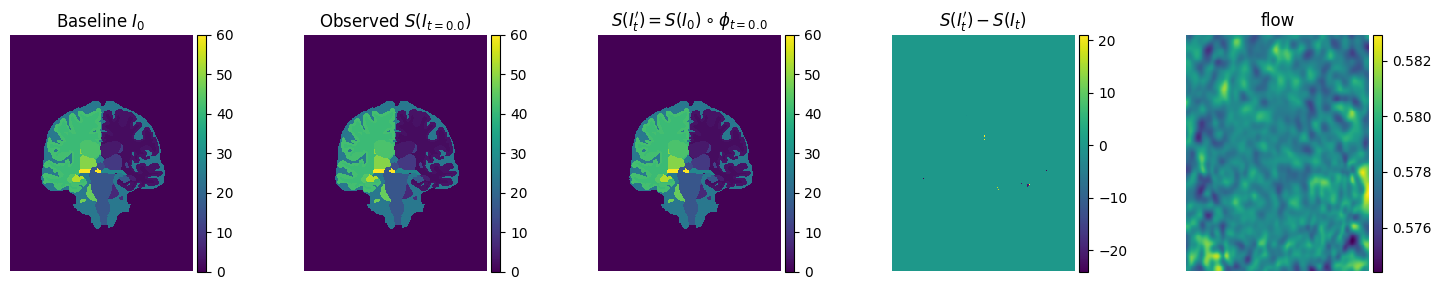

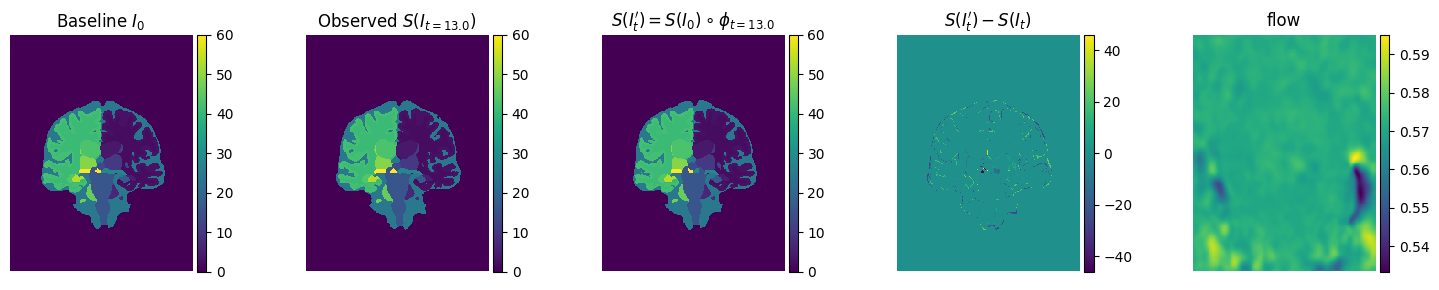

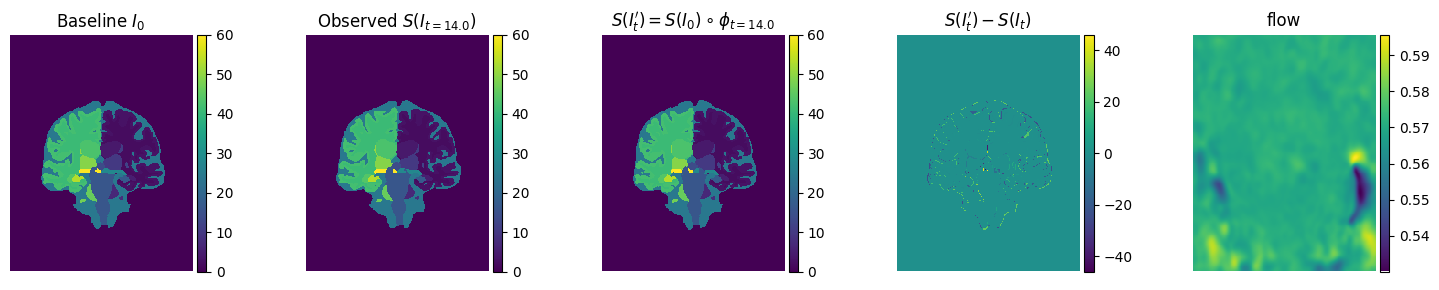

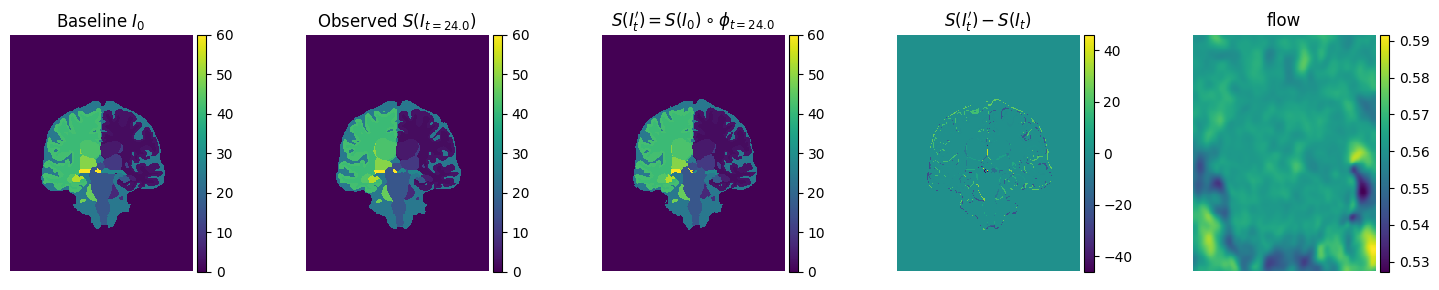

In [10]:
#warp the labbeled I0 with deformation field to compute dice between moved_I0 and It_seg


stack_moved_seg = []
video_images_seg = []
video_titles_seg = []
I0_seg = load_data(datapath +"../labels/I0_seg.nii", False)
z = 150
image_mask_2d_seg = I0_mask[:, z, :] 
I0_2d_seg = I0_seg[:, z, :].cpu().numpy()


for idx, selected_time in enumerate(time):
    It_seg = load_data(datapath +f"../labels/I{idx}_seg.nii", False)

    
    moved_seg = transform.nearest_neighbor_interpolation(stack_total_deformation_field[idx].to(device), I0_seg).view(I0_seg.shape)  
    stack_moved_seg.append(moved_seg.cpu().numpy().squeeze())


    It_2d_seg = It_seg[:, z, :].cpu().numpy()
    moved_2d_label = moved_seg[:, z, :].cpu().numpy()

    residual = moved_2d_label-It_2d_seg 
    
    tdf_2d = stack_tdf[idx][:, z, :].cpu().numpy()
    masked_tdf = image_masking(tdf_2d, image_mask_2d, True )

    images = [I0_2d_seg, It_2d_seg, moved_2d_label,  residual, masked_tdf[..., 1]] 
    titles = [
        r'Baseline $I_0$', 
        r'Observed $S(I_{t=' + str(selected_time.item()) + '})$', 
        r"$S(I_{t}') = S(I_0)  \circ \phi_{t=" + str(selected_time.item()) + "}$", 
        r"$S(I_{t}') - S(I_t)$",
        'flow'
    ]
    video_images_seg.append(images)
    video_titles_seg.append(titles)
    
    ne.plot.slices(images, titles=titles, do_colorbars=True,  cmaps=['viridis']);

    wandb.log({"Transformed segmentation maps": [wandb.Image(image, caption=title) for image, title in zip(images, titles)]})




## CREATING MEAN |J| MASKS AND SAVING RESULTS


In [11]:
structures = [
    "lateral_ventricle",
    "thalamus",
    "caudate",
    "putamen",
    "pallidum",
    "hippocampus",
    "amygdala"
]

left_structures = [4, 10, 11, 12, 13, 17, 18]
right_structures = [43, 49, 50, 51, 52, 53, 54]
result_path = "result/"+logger_name+".csv"

def dice_score(label1, label2):
    intersection = np.sum(label1[label1 > 0] == label2[label1 > 0])
    dice = (2 * intersection) / (np.sum(label1) + np.sum(label2))
    return dice

def combine_labels(img1, img2, state = "Dice Score"):

    total_dice = 0
    structure_dice = {}

    for i, structure in enumerate(structures):
        img1_combined = np.where(np.isin(img1, [left_structures[i], right_structures[i]]), 1, 0)
        img2_combined = np.where(np.isin(img2, [left_structures[i], right_structures[i]]), 1, 0)
        dice = dice_score(img1_combined, img2_combined)
        structure_dice[structure] = dice
        # print(f"{structure}: {dice:.4f}")
        total_dice+=dice
    print(f" {state} : {total_dice/len(structures)}")
    return structure_dice, total_dice/len(structures)

def compute_mean_jac_det(moved_label):
    mean_jacobian_determinants = {}
    for i, structure in enumerate(structures):
        mask =  np.where(np.isin(moved_label, [left_structures[i], right_structures[i]]), 1, 0)
        
        jacobian_values = det[mask > 0]
        mean_jacobian_determinants[structure] = jacobian_values.mean().item()
    return mean_jacobian_determinants


for selected_time in time:
    It_seg = load_data(datapath +f"../labels/I{idx}_seg.nii", False)
    It_seg = It_seg.cpu().numpy()
         
    structure_dice_affine, total_dice_affine = combine_labels(I0_seg.cpu().numpy(), It_seg, selected_time,"Dice between I0 and It (affine)")
    structure_dice_target_predicted, total_dice_target_predicted = combine_labels(stack_moved_seg[idx], It_seg, selected_time, "Dice at It and It\'(target vs predicted)")

    det = stack_total_jac_det[idx]
    mean_jac_det = compute_mean_jac_det(stack_moved_seg[idx])
    number_of_folds = (det<=0).sum().item()
    number_of_expansions = (det>1).sum().item()
    number_of_contractions= ((det > 0) & (det < 1)).sum().item()
    no_volume_change =  (det==1).sum().item()

    if not os.path.exists(result_path):
        with open(result_path, 'w') as f:
            writer = csv.writer(f)
            writer.writerow(["subjectID", "selected_time", "structure", "structure_mean_jac_det", "jac_det_mean","jac_det_min", "jac_det_max","structure_dice_affine", "structure_dice_target_predicted",
                            "total_dice_affine", "total_dice_target_predicted", "number_of_folds", "number_of_expansions", "number_of_contractions", "no_volume_change"])

    try:

        with open(result_path, 'a') as f:
            if selected_time not in time: # when interpolating or extrapolating
                for i, structure in enumerate(structures):
                    writer = csv.writer(f)
                    rows = [imagepath.split("/")[2], selected_time, structure, mean_jac_det[structure], det.mean().item(),
                        det.min().item(), det.max().item(), np.nan, np.nan, 
                        np.nan, np.nan, number_of_folds, number_of_expansions, number_of_contractions, no_volume_change]
                    writer.writerow(rows)
                    
            else:
                for i, structure in enumerate(structures):
                    writer = csv.writer(f)
                    rows = [imagepath.split("/")[2], selected_time, structure, mean_jac_det[structure], det.mean().item(),
                        det.min().item(), det.max().item(), structure_dice_affine[structure], structure_dice_target_predicted[structure], 
                        total_dice_affine, total_dice_target_predicted, number_of_folds, number_of_expansions, number_of_contractions, no_volume_change]
                    writer.writerow(rows)

            
                
    except FileNotFoundError:
        print(f"Error: Could not write to file {result_path}")
    # wandb.log({"Results": wandb.Table(data= pd.read_csv(result_path))})

NameError: name 'observed_time' is not defined

In [ ]:
structures = [
    "lateral_ventricle",
    "thalamus",
    "caudate",
    "putamen",
    "pallidum",
    "hippocampus",
    "amygdala"
]

left_structures = [4, 10, 11, 12, 13, 17, 18]
right_structures = [43, 49, 50, 51, 52, 53, 54]
result_path = "result/"+logger_name+".csv"

def dice_score(label1, label2):
    intersection = np.sum(label1[label1 > 0] == label2[label1 > 0])
    dice = (2 * intersection) / (np.sum(label1) + np.sum(label2))
    return dice

def combine_labels(img1, img2, state = "Dice Score"):

    total_dice = 0
    structure_dice = {}

    for i, structure in enumerate(structures):
        img1_combined = np.where(np.isin(img1, [left_structures[i], right_structures[i]]), 1, 0)
        img2_combined = np.where(np.isin(img2, [left_structures[i], right_structures[i]]), 1, 0)
        dice = dice_score(img1_combined, img2_combined)
        structure_dice[structure] = dice
        # print(f"{structure}: {dice:.4f}")
        total_dice+=dice
    print(f" {state} : {total_dice/len(structures)}")
    return structure_dice, total_dice/len(structures)

def compute_mean_jac_det(moved_label):
    mean_jacobian_determinants = {}
    for i, structure in enumerate(structures):
        mask =  np.where(np.isin(moved_label, [left_structures[i], right_structures[i]]), 1, 0)
        
        jacobian_values = det[mask > 0]
        mean_jacobian_determinants[structure] = jacobian_values.mean().item()
    return mean_jacobian_determinants


structure_dice_affine, total_dice_affine = combine_labels(I0_seg.cpu().numpy() * I0_mask, It_seg.cpu().numpy() * I0_mask, "Dice between I0 and It (affine)")
structure_dice_target_predicted, total_dice_target_predicted = combine_labels(moved_seg * I0_mask, It_seg.cpu().numpy() * I0_mask, "Dice at It and It\'(target vs predicted)")

det = total_jac_det
mean_jac_det = compute_mean_jac_det(moved_seg)
number_of_folds = (det<=0).sum().item()
number_of_expansions = (det>1).sum().item()
number_of_contractions= ((det > 0) & (det < 1)).sum().item()
no_volume_change =  (det==1).sum().item()

if not os.path.exists(result_path):
    with open(result_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["subjectID", "structure", "structure_mean_jac_det", "jac_det_mean","jac_det_min", "jac_det_max","structure_dice_affine", "structure_dice_target_predicted",
                        "total_dice_affine", "total_dice_target_predicted", "number_of_folds", "number_of_expansions", "number_of_contractions", "no_volume_change"])

try:

    with open(result_path, 'a') as f:
    
            
        for i, structure in enumerate(structures):
            writer = csv.writer(f)
            rows = [datapath.split("/")[2],  structure, mean_jac_det[structure], det.mean().item(),
                det.min().item(), det.max().item(), structure_dice_affine[structure], structure_dice_target_predicted[structure], 
                total_dice_affine, total_dice_target_predicted, number_of_folds, number_of_expansions, number_of_contractions, no_volume_change]
            writer.writerow(rows)

        
except FileNotFoundError:
    print(f"Error: Could not write to file {result_path}")

wandb.log({"Results": wandb.Table(data= pd.read_csv(result_path))})